# Notebook settings

In [1]:
do_training = False

# Imports

In [2]:
from zipfile import ZipFile

from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import ResNet50_Weights, ResNet18_Weights
# Voir si c'est torch ou torchvision à ce niveau

import pytorch_lightning as pl

from typing import Any, Dict, Callable, Tuple

from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

# from captum.attr import DeepLift, DeepLiftShap, GradientShap, Saliency
import captum.attr as explain
from captum.attr import visualization as viz
import numpy as np

from os.path import isdir

from src.models.resnet import resnet50, resnet18

import matplotlib.pyplot as plt

/home/loic/projets/explainability_interpretability_robustness/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Extract and load data

## Extract and load train/test sets

In [3]:
archive_path = '../data/fruits_vegetables_360.zip'

if not isdir('../data/fruits_vegetables_360/'):
  with ZipFile(archive_path, mode='r') as zip:
    zip.extractall('../data/fruits_vegetables_360/')

train_set = ImageFolder('../data/fruits_vegetables_360/fruits-360_dataset/fruits-360/Training/', transform=transforms.ToTensor())
test_set = ImageFolder('../data/fruits_vegetables_360/fruits-360_dataset/fruits-360/Test/', transform=transforms.ToTensor())

## Split training set into training and validation sets

In [4]:
train_ratio = 0.9
total_size = len(train_set)

train_size = int(train_ratio * total_size)
valid_size = total_size - train_size

train_set, valid_set = random_split(train_set, [train_size, valid_size])

Look at set sizes

In [5]:
len(train_set), len(valid_set), len(test_set)

(60922, 6770, 22688)

# ResNet
Simple to use and simple to use explainability process on it.

## Load and freeze weights for finetuning

We freeze the entire model weights and biases just to keep classifier learnable.  
We want to keep initial features extractor.

In [6]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

model.fc = nn.Linear(in_features=512, out_features=131)

for name, params in model.named_parameters():
    if 'fc' in name:
        continue
    params.requires_grad = False

# PyTorch Lightning wrapper

In [7]:
class LightningWrapper(pl.LightningModule):
  def __init__(self, model: nn.Module, loss_function: Callable=F.cross_entropy, optimizer: torch.optim.Optimizer=torch.optim.Adam, 
               optimizer_params: Dict[str, Any]={'lr': 0.001}, **pl_module) -> None:
    super(LightningWrapper, self).__init__(**pl_module)
    self.save_hyperparameters()
    self.wrapped_model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.optimizer_params = optimizer_params

  def configure_optimizers(self) -> torch.optim.Optimizer:
    return self.optimizer(self.parameters(), **self.optimizer_params)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.wrapped_model(x)
  
  def training_step(self, train_batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    inputs, targets = train_batch
    outputs = self.wrapped_model(inputs)
    loss = self.loss_function(outputs, targets)
    self.log('train_loss', loss)
    return loss
  
  def validation_step(self, valid_batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    inputs, targets = valid_batch
    outputs = self.wrapped_model(inputs)
    loss = self.loss_function(outputs, targets)
    self.log('valid_loss', loss)
    return loss
  
  def test_step(self, valid_batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    inputs, targets = valid_batch
    outputs = self.wrapped_model(inputs)
    loss = self.loss_function(outputs, targets)
    self.log('test_loss', loss)
    return loss
  
  def predict_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
    inputs = batch
    outputs = self.wrapped_model(inputs)
    return torch.softmax(outputs)

Config Lightning Trainer

In [8]:
model_checkpoint = ModelCheckpoint(
    dirpath='../data/lightning_logs/finetuning_resnet50_fv/',
    save_last=True,
    every_n_epochs=1
)

# Training

In [9]:
# Model and trainer
lightning_model = LightningWrapper(model) if do_training else LightningWrapper.load_from_checkpoint('../data/lightning_logs/finetuning_resnet50_fv/last-v4.ckpt')

device = 'gpu' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(accelerator=device, max_epochs=25, callbacks=[model_checkpoint])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=512, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=2)
test_loader = DataLoader(test_set, batch_size=512, num_workers=2)

if do_training:
  # Training
  trainer.fit(lightning_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

/home/loic/projets/explainability_interpretability_robustness/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Testing

In [10]:
# trainer.test(lightning_model, dataloaders=test_loader)

# Explicability / Interpretability with Captum

In [11]:
import random as rand
random_indexes = rand.sample([i for i in range(len(train_set))], k=5)

## DeepLIFT

/home/loic/projets/explainability_interpretability_robustness/.venv/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


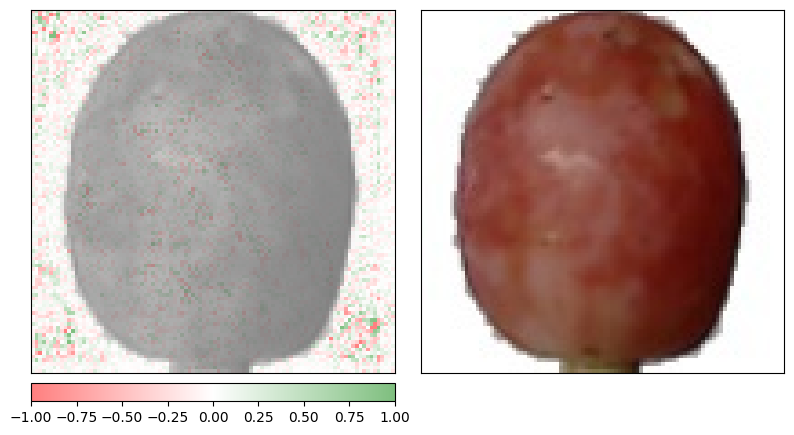

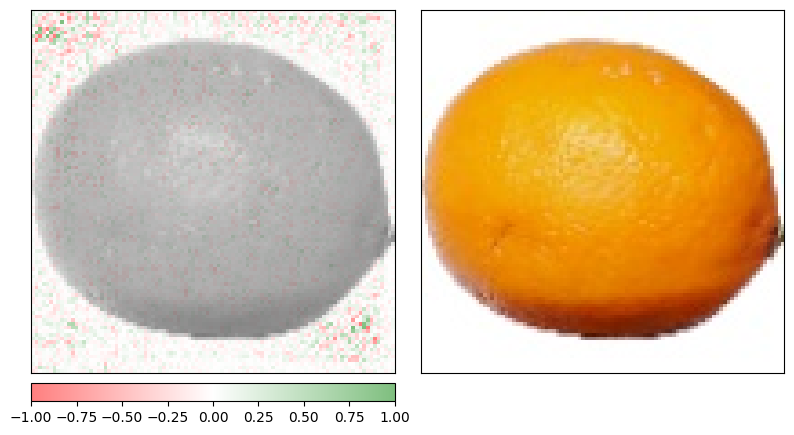

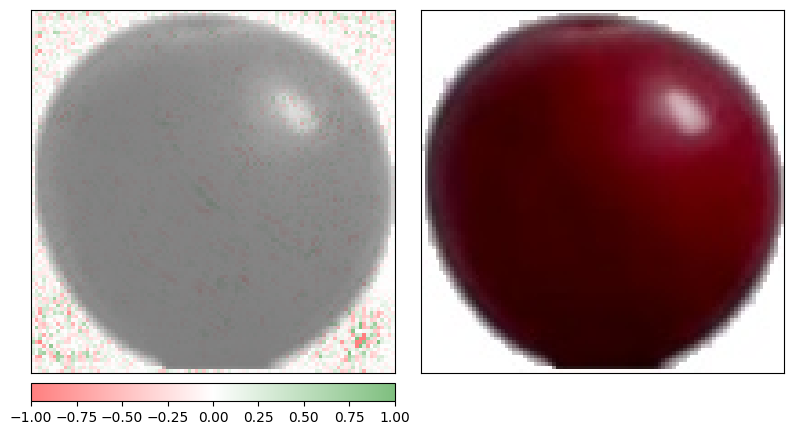

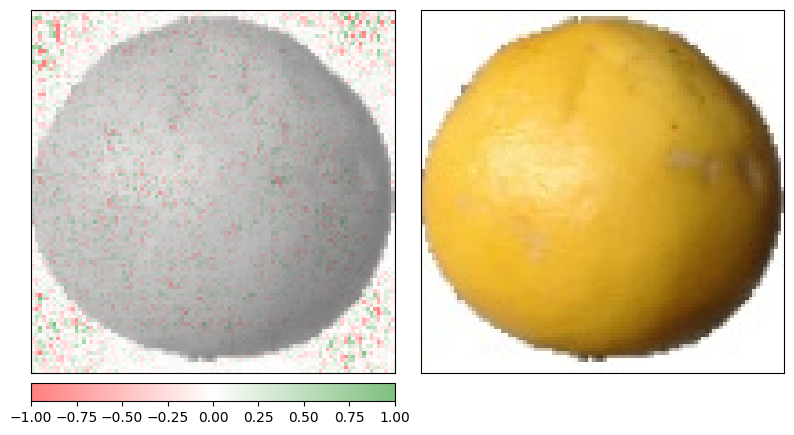

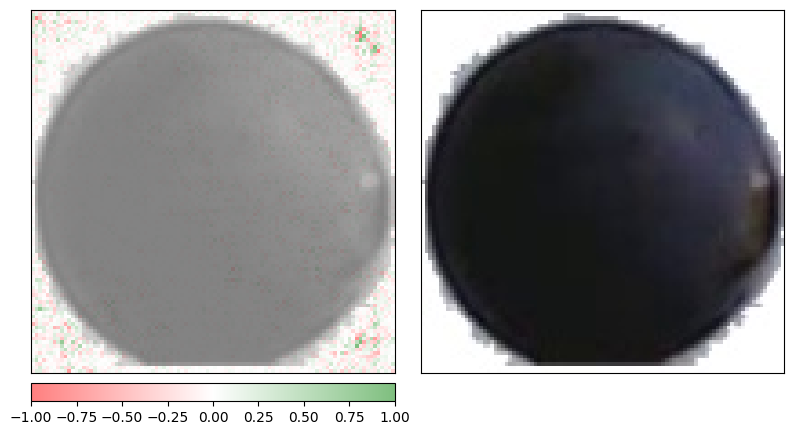

In [12]:
for ind in random_indexes:
    img, tgt = train_set[ind]
    img = img.unsqueeze(0)
    img.requires_grad = True

    deeplift = explain.DeepLift(lightning_model.wrapped_model)
    attribution = deeplift.attribute(img, target=tgt)

    original_image = np.transpose(img.squeeze().cpu().detach().numpy(), (1, 2, 0))
    deeplift_image = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1, 2, 0))
    _ = viz.visualize_image_attr_multiple(deeplift_image, original_image, methods=['blended_heat_map', 'original_image'], signs=['all', 'absolute_value'], show_colorbar=True)

## LIME

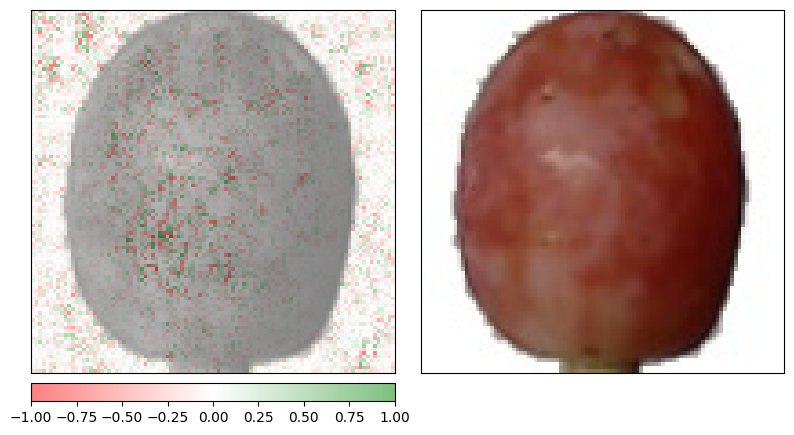

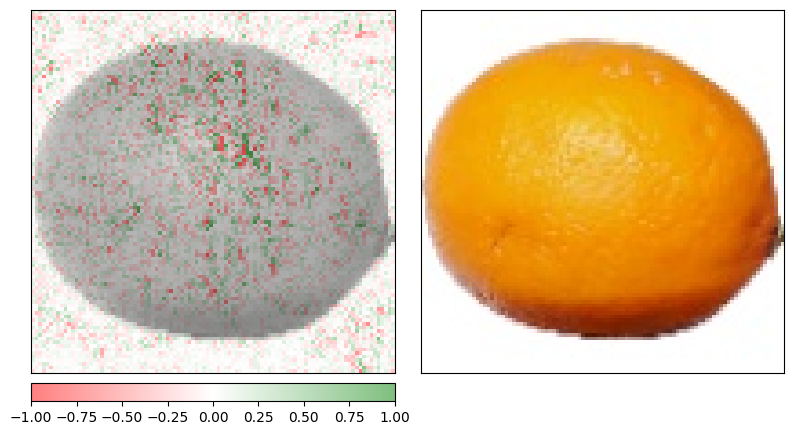

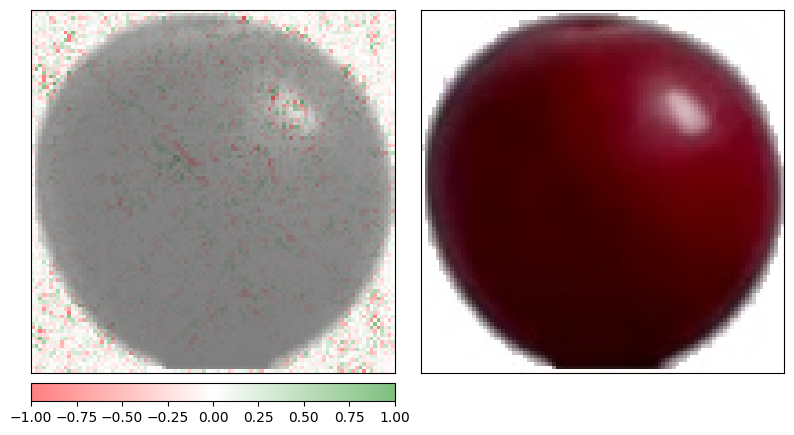

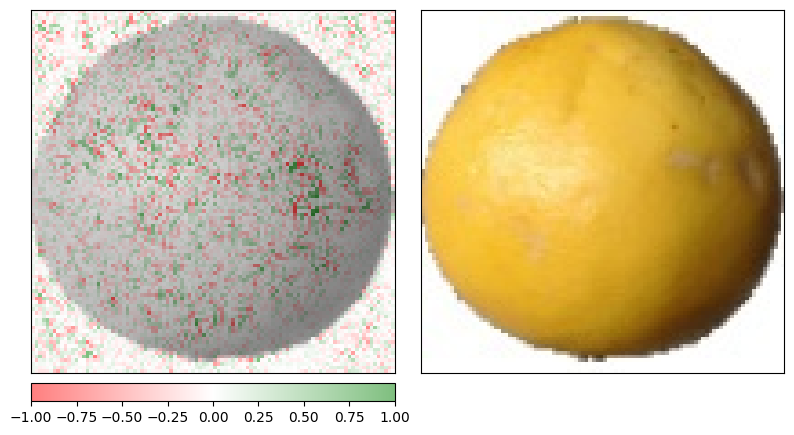

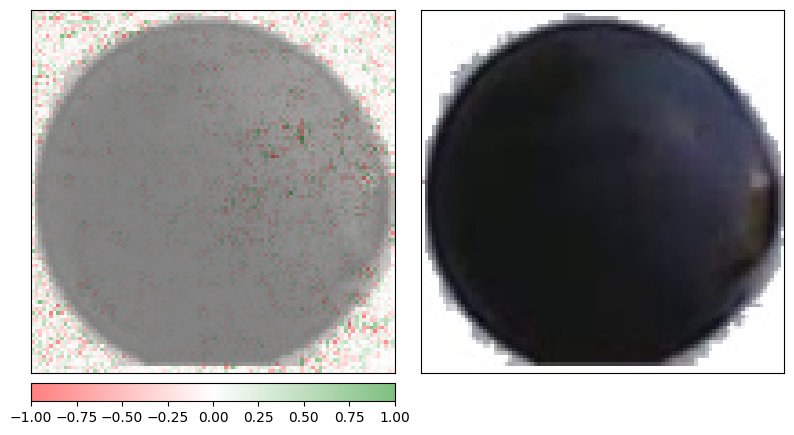

In [14]:
for ind in random_indexes:
    img, tgt = train_set[ind]
    img = img.unsqueeze(0)
    img.requires_grad = True

    integrated_gradients = explain.IntegratedGradients(lightning_model.wrapped_model)
    attribution = integrated_gradients.attribute(img, target=tgt)

    original_image = np.transpose(img.squeeze().cpu().detach().numpy(), (1, 2, 0))
    integrated_gradients_image = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1, 2, 0))
    _ = viz.visualize_image_attr_multiple(integrated_gradients_image, original_image, methods=['blended_heat_map', 'original_image'], signs=['all', 'absolute_value'], show_colorbar=True)